In [1]:
import numpy as np
import sys
import os
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
sys.path.append(os.path.abspath('C:/Users/vpming/tuni_ml/src'))
from extract_data import build_features_100samples_df, extract_noise

In [3]:
data_path = 'C:/Users/vpming/tuni_ml/data_7x7'
all_df = build_features_100samples_df(data_path)

In [10]:
min_count = all_df['dis_to_target'].value_counts().min()

n_samples = min_count

# Balance the df
df = (
    all_df.groupby('dis_to_target', group_keys=False)
    .apply(lambda x: x.sample(n=n_samples, random_state=42))
    .reset_index(drop=True)
)

print(df['dis_to_target'].value_counts())

C:\Users\vpming\AppData\Local\Temp\ipykernel_188\1389712327.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_samples, random_state=42))


dis_to_target
0    12000
1    12000
2    12000
3    12000
4    12000
5    12000
Name: count, dtype: int64


In [11]:
df['noise'] = df['simulation_file'].apply(extract_noise)

In [14]:
x_tt = np.stack(df['time_trace'])
x_c = df[['cMax', 'cVariance']].values

x = np.hstack([x_tt, x_c])

y = df['dis_to_target'].values

# 4 classes: 0, 1, 2, 3, 4, 5
n_bins = 6
bins = np.linspace(y.min(), y.max(), n_bins + 1)
y_class = np.digitize(y, bins[1:-1])  # produces class labels 0,1,2,3,4,5

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.2, random_state=42)

# Scale only the input features
x_scaler = StandardScaler()
x_train_s = x_scaler.fit_transform(x_train)
x_test_s = x_scaler.transform(x_test)

# Do NOT scale y for classification!
train_ds = TensorDataset(torch.tensor(x_train_s, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(x_test_s, dtype=torch.float32),
                        torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [18]:
print(x.shape[0])

72000


In [25]:
class CNNClassifier(nn.Module):
    def __init__(self, n_timepoints, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * (n_timepoints // 4), 64),
            nn.ReLU(),
            nn.Linear(64, n_classes) 
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        return self.fc(x)  

In [20]:
def evaluate(model, data_loader, loss_fn):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
    avg_loss = running_loss / total
    acc = 100 * correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels

In [23]:
def fit(model, train_loader, test_loader, epochs=20):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        avg_loss = running_loss / total
        acc = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        # Evaluate on test
        test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} Train Loss: {avg_loss:.4f}  Train Accuracy: {acc:.2f}%  Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.2f}%')
        
    torch.save({
        'model_state_dict': model.state_dict()
    }, "C:/Users/vpming/tuni_ml/src/model/cnn_cmax_cvar_tt.pt")

    # Plot losses and accuracies
    epochs_range = np.arange(1, epochs+1)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, test_accs, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    # Confusion matrix for final test predictions
    plt.subplot(1, 3, 3)
    conf_mat = confusion_matrix(test_labels, test_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

    return train_losses, test_losses, train_accs, test_accs, conf_mat

Epoch 5/20 Train Loss: 1.0802  Train Accuracy: 50.56%  Test Loss: 1.1275  Test Accuracy: 47.92%
Epoch 10/20 Train Loss: 0.9741  Train Accuracy: 56.48%  Test Loss: 1.2086  Test Accuracy: 47.30%
Epoch 15/20 Train Loss: 0.7986  Train Accuracy: 65.28%  Test Loss: 1.5178  Test Accuracy: 46.06%
Epoch 20/20 Train Loss: 0.6375  Train Accuracy: 73.02%  Test Loss: 2.0379  Test Accuracy: 44.83%


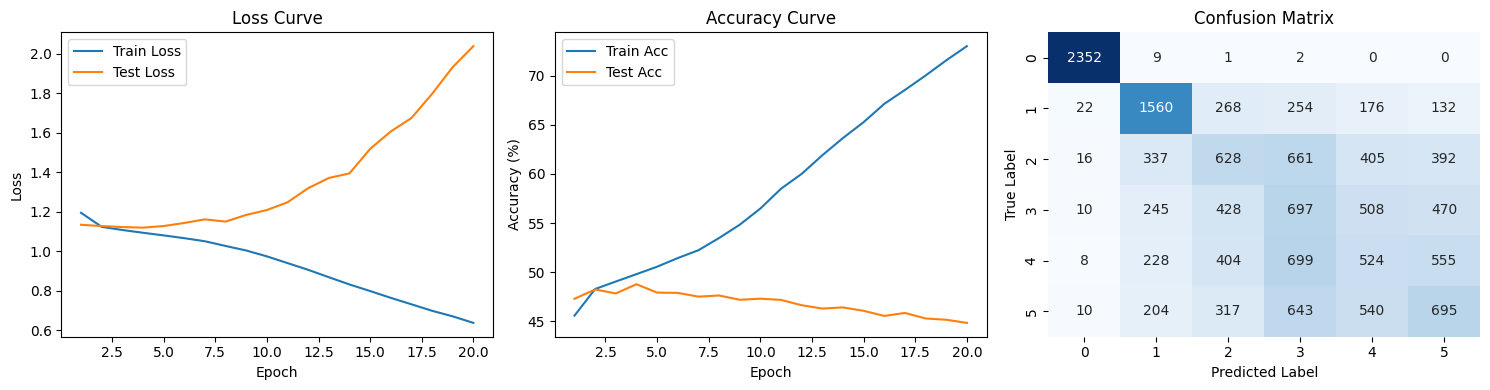

([1.1947232644425498,
  1.123628981113434,
  1.1076123227675756,
  1.0935621027814018,
  1.080238526860873,
  1.066188860601849,
  1.0504972160524793,
  1.0267671324147118,
  1.0037750964694554,
  0.9741172721650866,
  0.940108954111735,
  0.9059459325340059,
  0.8686498945289188,
  0.831998180647691,
  0.7985522582133611,
  0.7641887333658006,
  0.7315448423557811,
  0.6986903814805878,
  0.6705526961220636,
  0.6374530396858851],
 [1.1340046371353998,
  1.1273961888419257,
  1.122415836122301,
  1.1195461924870809,
  1.1275271802478366,
  1.1431823354297215,
  1.1613233341111078,
  1.1500810752974615,
  1.1839401115311516,
  1.2085904076364304,
  1.2477244120173985,
  1.3192606721984015,
  1.370876059267256,
  1.3941745710372926,
  1.517831792831421,
  1.6062314229541355,
  1.6742051924599541,
  1.7964706500371297,
  1.9319384124543932,
  2.0379096921284994],
 [45.576388888888886,
  48.286458333333336,
  49.045138888888886,
  49.796875,
  50.55555555555556,
  51.435763888888886,
  52

In [26]:
# Define model
n_timepoints = x_train.shape[1]
n_classes = len(np.unique(y_train))
model = CNNClassifier(n_timepoints, n_classes)

fit(model, train_loader, test_loader)


=== Training for noise 0.01 ===
Training on 12015 samples; Testing on 3004 samples
Epoch 5/15 Train Loss: 0.8370  Train Accuracy: 61.15%  Test Loss: 0.8881  Test Accuracy: 56.56%
Epoch 10/15 Train Loss: 0.6415  Train Accuracy: 72.77%  Test Loss: 1.0726  Test Accuracy: 54.06%
Epoch 15/15 Train Loss: 0.2665  Train Accuracy: 90.40%  Test Loss: 1.7154  Test Accuracy: 53.86%


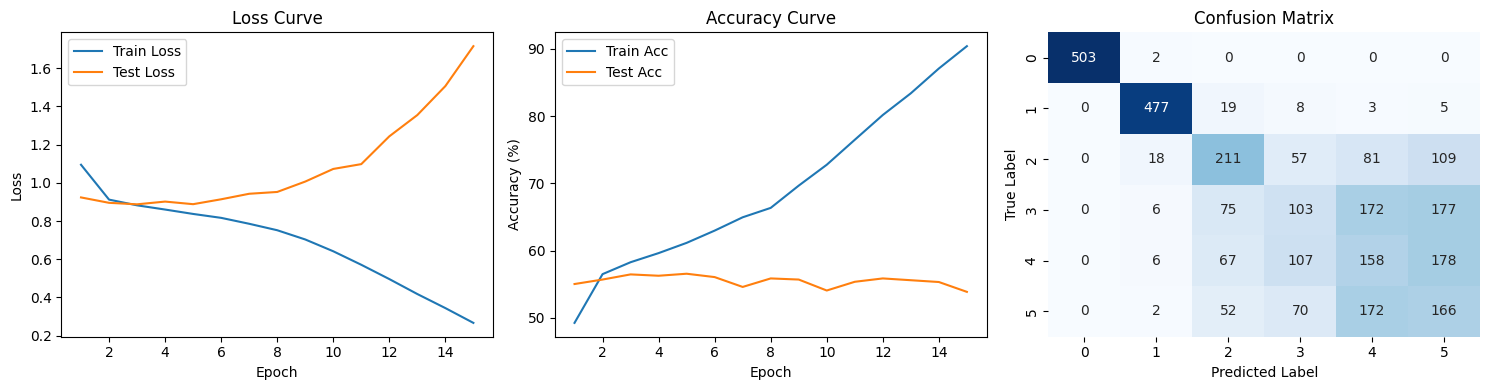


=== Training for noise 0.02 ===
Training on 12056 samples; Testing on 3015 samples
Epoch 5/15 Train Loss: 0.9852  Train Accuracy: 55.75%  Test Loss: 1.0977  Test Accuracy: 48.86%
Epoch 10/15 Train Loss: 0.5278  Train Accuracy: 79.74%  Test Loss: 1.5873  Test Accuracy: 46.93%
Epoch 15/15 Train Loss: 0.0655  Train Accuracy: 98.55%  Test Loss: 3.3128  Test Accuracy: 46.27%


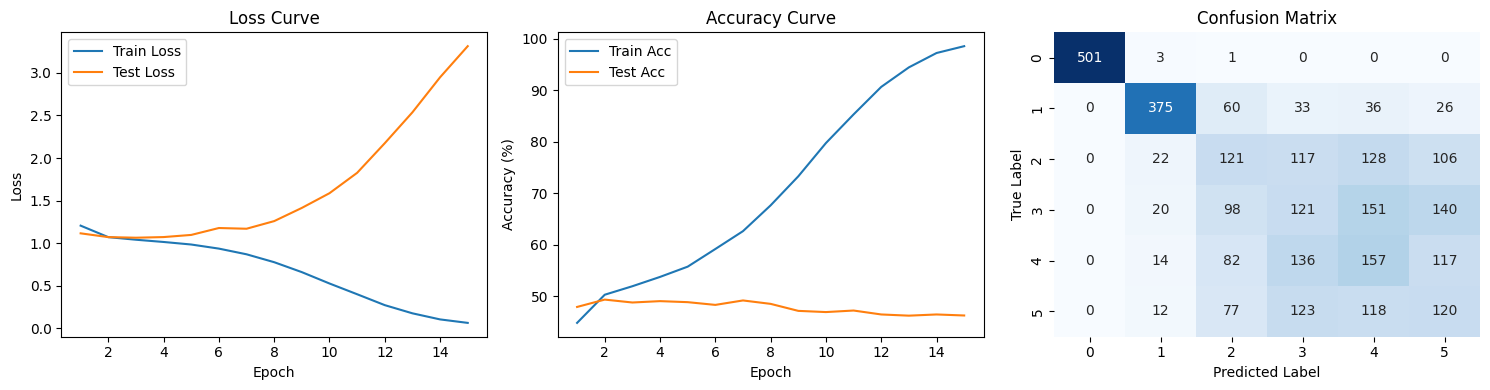


=== Training for noise 0.03 ===
Training on 12132 samples; Testing on 3033 samples
Epoch 5/15 Train Loss: 1.0863  Train Accuracy: 52.19%  Test Loss: 1.1675  Test Accuracy: 46.62%
Epoch 10/15 Train Loss: 0.7606  Train Accuracy: 69.45%  Test Loss: 1.5312  Test Accuracy: 44.64%
Epoch 15/15 Train Loss: 0.2951  Train Accuracy: 89.41%  Test Loss: 2.6782  Test Accuracy: 42.33%


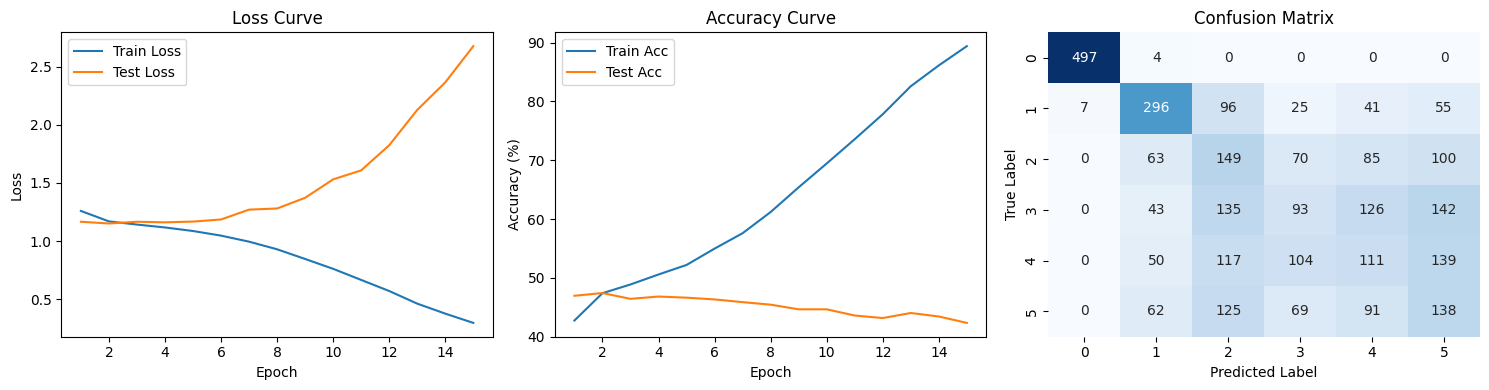


=== Training for noise 0.04 ===
Training on 11863 samples; Testing on 2966 samples
Epoch 5/15 Train Loss: 1.1313  Train Accuracy: 51.84%  Test Loss: 1.2648  Test Accuracy: 44.10%
Epoch 10/15 Train Loss: 0.7487  Train Accuracy: 71.10%  Test Loss: 1.6615  Test Accuracy: 41.94%
Epoch 15/15 Train Loss: 0.2306  Train Accuracy: 92.57%  Test Loss: 2.9796  Test Accuracy: 41.44%


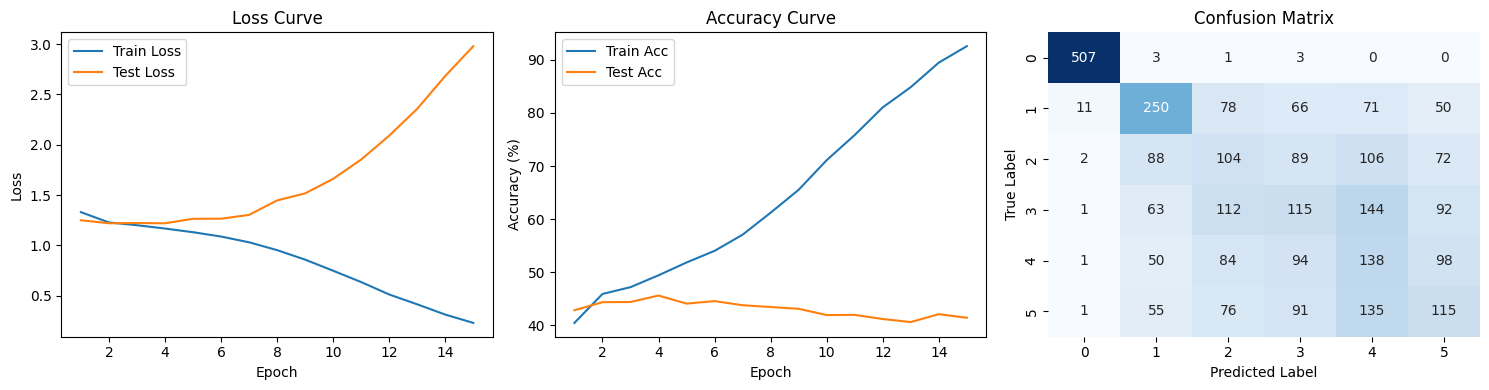


=== Training for noise 0.05 ===
Training on 9532 samples; Testing on 2384 samples
Epoch 5/15 Train Loss: 1.1527  Train Accuracy: 50.88%  Test Loss: 1.3007  Test Accuracy: 43.71%
Epoch 10/15 Train Loss: 0.7673  Train Accuracy: 69.83%  Test Loss: 1.7385  Test Accuracy: 39.68%
Epoch 15/15 Train Loss: 0.2524  Train Accuracy: 91.41%  Test Loss: 3.1359  Test Accuracy: 39.26%


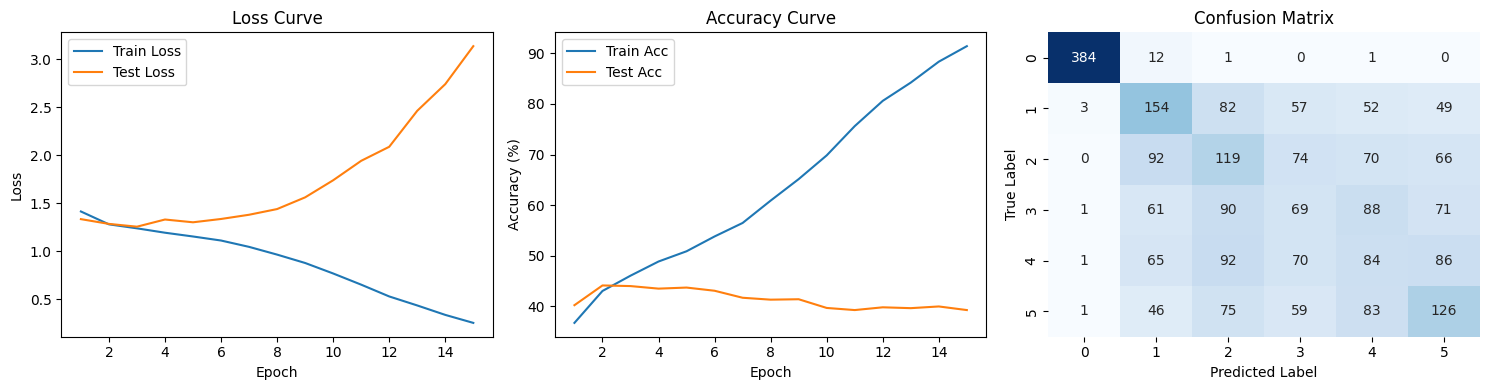

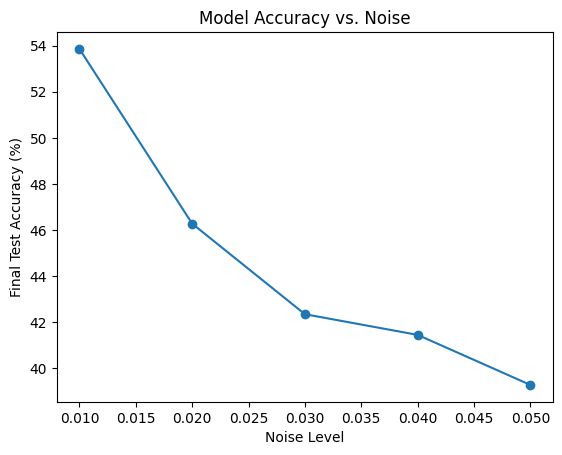

In [29]:
results = []

for noise_level in sorted(df['noise'].unique()):
    print(f'\n=== Training for noise {noise_level} ===')
    mask = df['noise'] == noise_level
    
    x_tt = np.stack(df.loc[mask, 'time_trace'])
    x_c = df.loc[mask, ['cMax','cVariance']].values            # shape (n_samples_for_noise, 2)
    X = np.hstack([x_tt, x_c])
    y = df.loc[mask, 'dis_to_target'].values  

    n_bins = 6
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    y_class = np.digitize(y, bins[1:-1])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test_s, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Define model for this run
    n_timepoints = X_train.shape[1]
    n_classes = len(np.unique(y_train))
    model = CNNClassifier(n_timepoints, n_classes)

    # Train & evaluate (use your fit function)
    print(f"Training on {X_train.shape[0]} samples; Testing on {X_test.shape[0]} samples")
    train_losses, test_losses, train_accs, test_accs, conf_mat = fit(model, train_loader, test_loader, epochs=15)
    results.append({'noise': noise_level, 'test_acc': test_accs[-1], 'confusion_matrix': conf_mat})

# Plot performance vs. noise
plt.plot([r['noise'] for r in results], [r['test_acc'] for r in results], marker='o')
plt.xlabel("Noise Level")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Model Accuracy vs. Noise") 
plt.show()